# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: L2 regularization in practice
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [53]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# load the dataloader
from torch.utils.data import DataLoader

In [54]:
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

In [55]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [56]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# create dataloader objects
train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# the model

In [57]:
# prompt: add a 15% droppout to the hidden layers in the `createANewModel` in the cell below:

def createANewModel():
  # create a model with linear layers
  model = nn.Sequential(
      nn.Linear(4,16),
      nn.ReLU(),
      nn.Dropout(p=0.15),
      nn.Linear(16,32),
      nn.ReLU(),
      nn.Dropout(p=0.15),
      nn.Linear(32,3),
      nn.LogSoftmax(dim=1)
  )
  return model


In [58]:
# a function that creates the ANN model

def createANewModel(L2lambda):

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Dropout(p=0.15),
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Dropout(p=0.15),
      nn.Linear(64,64),  # activation unit
      nn.ReLU(),
      nn.Dropout(p=0.15),
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005,weight_decay=L2lambda)

  return ANNiris,lossfun,optimizer

In [59]:
# train the model

# global parameter
numepochs = 1000

def trainTheModel():

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # need to toggle train mode here??

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    ANNiris.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

    # no worries, reset here ;)
    ANNiris.train()

  # function output
  return trainAcc,testAcc,losses


In [60]:
# create a model
L2lambda = .01
ANNiris,lossfun,optimizer = createANewModel(L2lambda)

# train the model
trainAcc,testAcc,losses = trainTheModel()


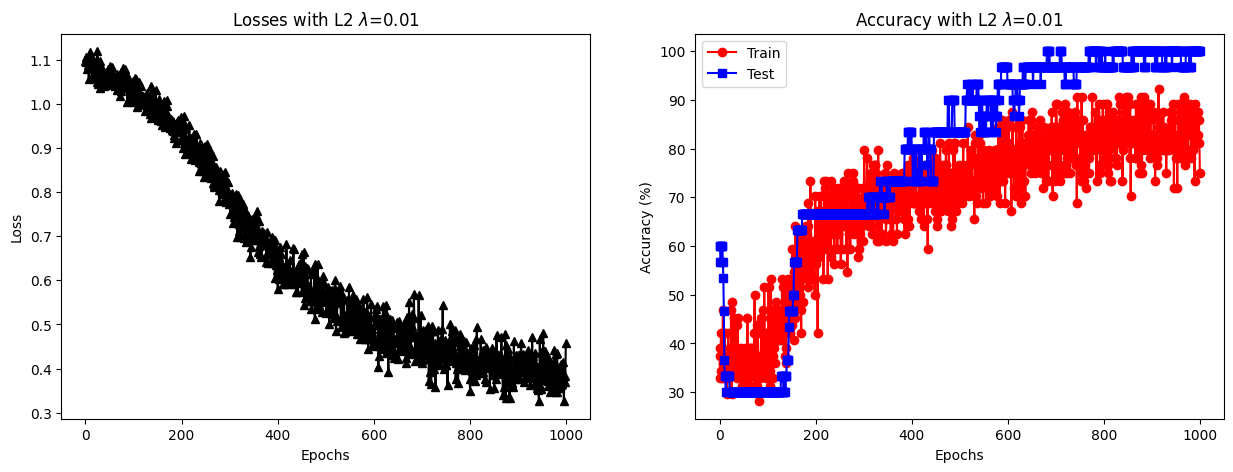

In [61]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [62]:
# create a 1D smoothing filter
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')

# The experiment

In [63]:
# range of L2 regularization amounts
l2lambdas = np.linspace(0,.1,10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(l2lambdas)))
accuracyResultsTest  = np.zeros((numepochs,len(l2lambdas)))


# loop over batch sizes
for li in range(len(l2lambdas)):

  # create and train a model
  ANNiris,lossfun,optimizer = createANewModel(l2lambdas[li])
  trainAcc,testAcc,losses = trainTheModel()

  # store data
  accuracyResultsTrain[:,li] = smooth(trainAcc,10)
  accuracyResultsTest[:,li]  = smooth(testAcc,10)

In [64]:
accuracyResultsTrain.shape, l2lambdas.shape

((1000, 10), (10,))

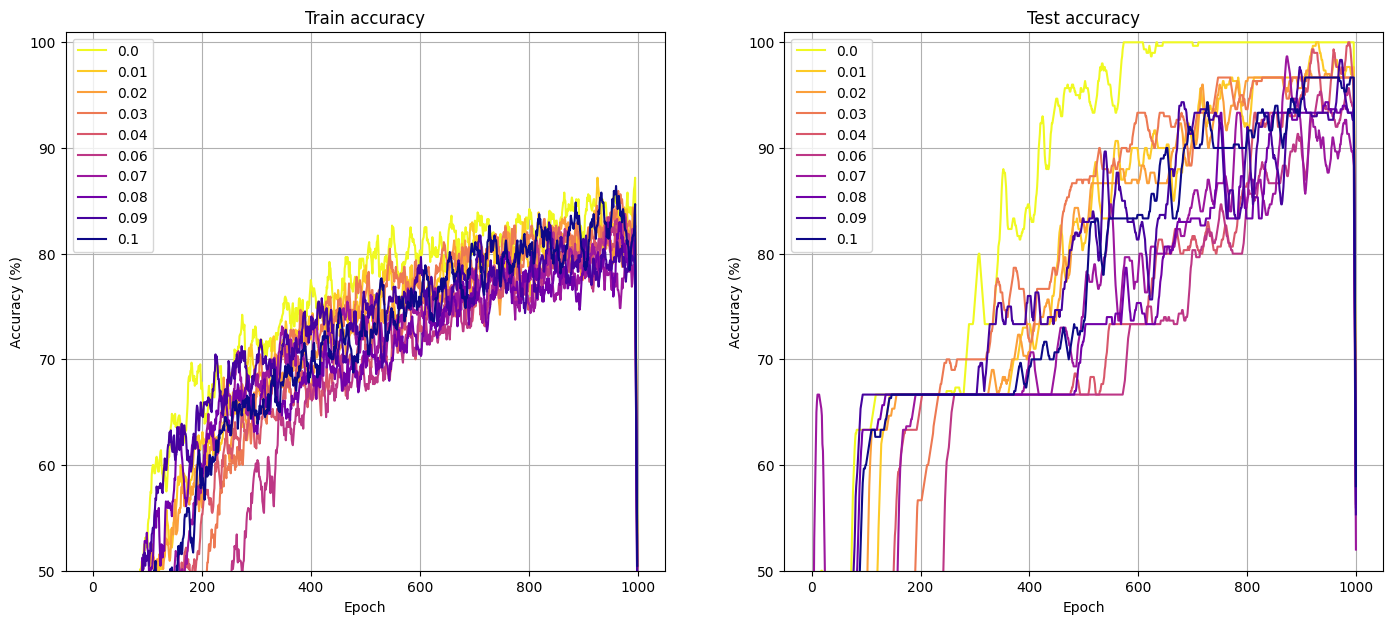

In [65]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

# the higher the l2, the darker the color
cmaps = plt.cm.plasma(np.linspace(1, 0, len(l2lambdas)))
for ii, l2 in enumerate(l2lambdas):
  ax[0].plot(accuracyResultsTrain[:, ii], color=cmaps[ii])
  ax[1].plot(accuracyResultsTest[:, ii], color=cmaps[ii])

ax[0].set_title('Train accuracy')
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,2) for i in l2lambdas]

# common features
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

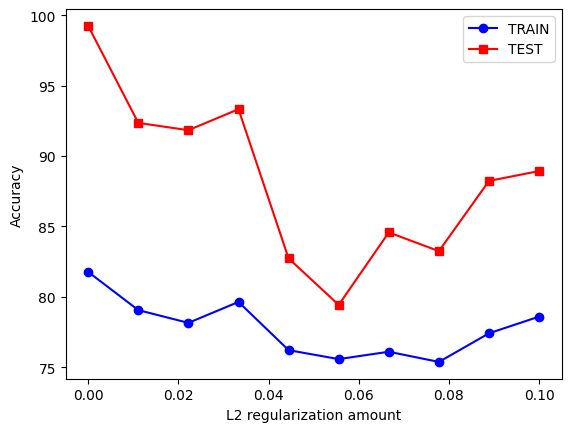

In [66]:
# show average accuracy by L2 rate

# average only some epochs
epoch_range = [500,950]


plt.plot(l2lambdas,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(l2lambdas,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Additional explorations

In [67]:
# 1) In general, regularization tends to benefit large, complex models, and has less impact (and sometimes even a negative
#    impact) on smaller or simpler model architectures. Modify the model architecture to have three hidden layers, and
#    see whether that changes the effect of L2 regularization on performance. (You might want to increase the number of
#    epochs.)
#
# 2) Multiple regularization methods can be combined. Add 15% dropout to the hidden layer(s) and see how that affects
#    the model's performance.
#

(0.0, 2.3625)

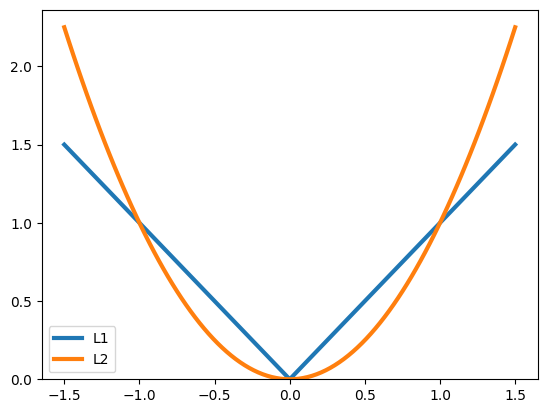

In [68]:
fig, ax = plt.subplots()
x = np.linspace(-1.5,1.5,101);
ax.plot(x, np.abs(x), label="L1", lw=3)
ax.plot(x, x**2, label="L2", lw=3)
ax.legend()
ax.set_ylim(0)